In [ ]:
import os
import pandas as pd
import torch
from ultra import datasets
# Snippet for generating statistics about the datasets
# List of dataset names
DATASETS = [
    "Epinions", "LastFM", "BookX", "Ml1m", "Gowalla",
    "Amazon_Beauty", "Amazon_Fashion", "Amazon_Men", "Amazon_Games", "Yelp18"
]

# Root folder for the data
DATA_ROOT = "/itet-stor/trachsele/net_scratch/tl4rec/model_outputs/data"

results = []

for ds in DATASETS:
    print(f"Processing dataset: {ds}")
    # Dynamically load the dataset class from ultra.datasets
    dataset_class = getattr(datasets, ds)
    dataset = dataset_class(root=DATA_ROOT)
    
    # Load train, valid, test PyG Data objects.
    train_data, valid_data, test_data = dataset[0], dataset[1], dataset[2]
    
    # Compute the number of directed edges from target_edge_index (for train and test)
    num_train_edges = train_data.target_edge_index.size(1)
    num_test_edges = test_data.target_edge_index.size(1)
    num_valid_edges = valid_data.target_edge_index.size(1)
    
    # Try to get the number of users and items from the dataset.
    # (Adjust this if your datasets store this information differently.)
    try:
        num_users = dataset.num_users
        num_items = dataset.num_items
    except AttributeError:
        # Fallback: if not available, set to None (or infer from the graph if possible)
        num_users = None
        num_items = None

    # Compute average degrees if num_users and num_items are known.
    if num_users is not None and num_items is not None:
        avg_user_degree_train = num_train_edges / num_users
        avg_item_degree_train = num_train_edges / num_items
        avg_user_degree_test  = num_test_edges / num_users
        avg_item_degree_test  = num_test_edges / num_items
        overall_density = (num_train_edges + num_test_edges +  num_valid_edges) / (num_users * num_items)
    else:
        avg_user_degree_train = avg_item_degree_train = None
        avg_user_degree_test = avg_item_degree_test = None
        overall_density = None

    # Get the dimension of edge attributes (from the train graph's edge_attr)
    if hasattr(train_data, 'edge_attr') and train_data.edge_attr is not None:
        edge_attr_dim = train_data.edge_attr.size(1)
    else:
        edge_attr_dim = None

    # Define the meaning of the edge attributes based on dataset name
    if ds == "Yelp18":
        edge_attr_meaning = "rating, date, useful, funny, cool"
    elif ds == "Gowalla":
        edge_attr_meaning = "Date, longitude, latitude"
    elif ds.startswith("Amazon_"):
        edge_attr_meaning = "context (already processed)"
    elif ds == "Ml1m":
        edge_attr_meaning = "rating and timestamp"
    elif ds == "BookX":
        edge_attr_meaning = "rating"
    elif ds == "LastFM":
        edge_attr_meaning = "listening count"
    elif ds == "Epinions":
        edge_attr_meaning = "categoryid, rating, helpfulness and time point"
    else:
        edge_attr_meaning = "unknown"

    results.append({
        "dataset": ds,
        "number_of_edges_train": num_train_edges,
        "number_of_edges_test": num_test_edges,
        "num_users": num_users,
        "num_items": num_items,
        "average_user_degree_train": avg_user_degree_train,
        "average_user_degree_test": avg_user_degree_test,
        "average_item_degree_train": avg_item_degree_train,
        "average_item_degree_test": avg_item_degree_test,
        "overall_density": overall_density,
        "edge_attr_dim": edge_attr_dim,
        "meaning_of_edge_attributes": edge_attr_meaning
    })

# Create a DataFrame from the collected statistics and save it as a CSV file.
df_results = pd.DataFrame(results)
print (df_results)
#output_csv = "graph_dataset_statistics.csv"
#df_results.to_csv(output_csv, index=False)
#print(f"Dataset statistics saved to {output_csv}")


In [6]:
import pandas as pd

# Load the dataset
file_path = '/itet-stor/trachsele/net_scratch/tl4rec/report_data/Dataset_Statistics.csv'
df = pd.read_csv(file_path)

# Rename datasets
df['dataset'] = df['dataset'].replace({'Ml1m': 'ML-1M'})
df['dataset'] = df['dataset'].str.replace(r'^Amazon_(\w+)', r'Amazon \1', regex=True)

# Save the modified dataset
output_path = '/itet-stor/trachsele/net_scratch/tl4rec/report_data/Dataset_Statistics_1.csv'
df.to_csv(output_path, index=False)
print ("done")


done


In [2]:
# generate csv with sota end-to-end and ckpt:import sqlite3
import sqlite3
import pandas as pd
import os

# Define the file path to save the resulting CSV
file_path = '/itet-stor/trachsele/net_scratch/tl4rec/report_data/ete_sota_0_shot_ft.csv'

# Connect to the database and load the experiments table.
DB_FILE = '/itet-stor/trachsele/net_scratch/tl4rec/model_outputs/results.db'
conn = sqlite3.connect(DB_FILE)
df = pd.read_sql("SELECT * FROM experiments", conn)
conn.close()

# List of datasets
DATASETS = [
    "Epinions", "LastFM", "BookX", "Ml1m", "Gowalla",
    "Amazon_Beauty", "Amazon_Fashion", "Amazon_Men", "Amazon_Games", "Yelp18"
]

# Prepare a list to collect the rows for the report.
report_rows = []

for ds in DATASETS:
    # --- SOTA ---
    # For SOTA, select the row where ckpt is 'SOTA' for the given dataset.
    df_sota = df[(df['dataset'] == ds) & (df['ckpt'] == 'SOTA')]
    if not df_sota.empty:
        row = df_sota.iloc[0].copy()
        row['setting'] = 'SOTA'
        report_rows.append(row)
    else:
        print(f"No SOTA row found for dataset {ds}")

    # --- End-to-End ---
    # For Amazon datasets: we select where ckpt == '-' (no epoch condition mentioned).
    # For other datasets: we select where ckpt equals "<dataset>.pth" and epochs == 1.
    if ds.startswith("Amazon"):
        df_e2e = df[(df['dataset'] == ds) & (df['ckpt'] == '-')]
    else:
        expected_ckpt = f"{ds}.pth"
        df_e2e = df[(df['dataset'] == ds) & (df['ckpt'] == expected_ckpt) & (df['epochs'] == 1)]
    if not df_e2e.empty:
        row = df_e2e.iloc[0].copy()
        row['setting'] = 'End-to-End'
        report_rows.append(row)
    else:
        print(f"No End-to-End row found for dataset {ds}")

    # --- 0-shot ---
    # For 0-shot, select the row where ckpt == 'Beau_Epin.pth' and epochs == 0.
    df_zero_shot = df[(df['dataset'] == ds) & (df['ckpt'] == 'Beau_Epin.pth') & (df['epochs'] == 0)]
    if not df_zero_shot.empty:
        row = df_zero_shot.iloc[0].copy()
        row['setting'] = '0-shot'
        report_rows.append(row)
    else:
        print(f"No 0-shot row found for dataset {ds}")

    # --- FT ---
    # For FT, select the row where ckpt == 'Beau_Epin.pth' and epochs == 1.
    df_ft = df[(df['dataset'] == ds) & (df['ckpt'] == 'Beau_Epin.pth') & (df['epochs'] == 1)]
    if not df_ft.empty:
        row = df_ft.iloc[0].copy()
        row['setting'] = 'FT'
        report_rows.append(row)
    else:
        print(f"No FT row found for dataset {ds}")

# Combine all collected rows into a new DataFrame.
df_report = pd.DataFrame(report_rows)

# (Optional) Rearrange columns to have dataset and setting at the front.
cols = df_report.columns.tolist()
for col in ['dataset', 'setting']:
    cols.remove(col)
df_report = df_report[['dataset', 'setting'] + cols]

# Ensure that the target directory exists.
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Save the resulting table as CSV.
df_report.to_csv(file_path, index=False)

print(f"Report saved to {file_path}")


Report saved to /itet-stor/trachsele/net_scratch/tl4rec/report_data/ete_sota_0_shot_ft.csv


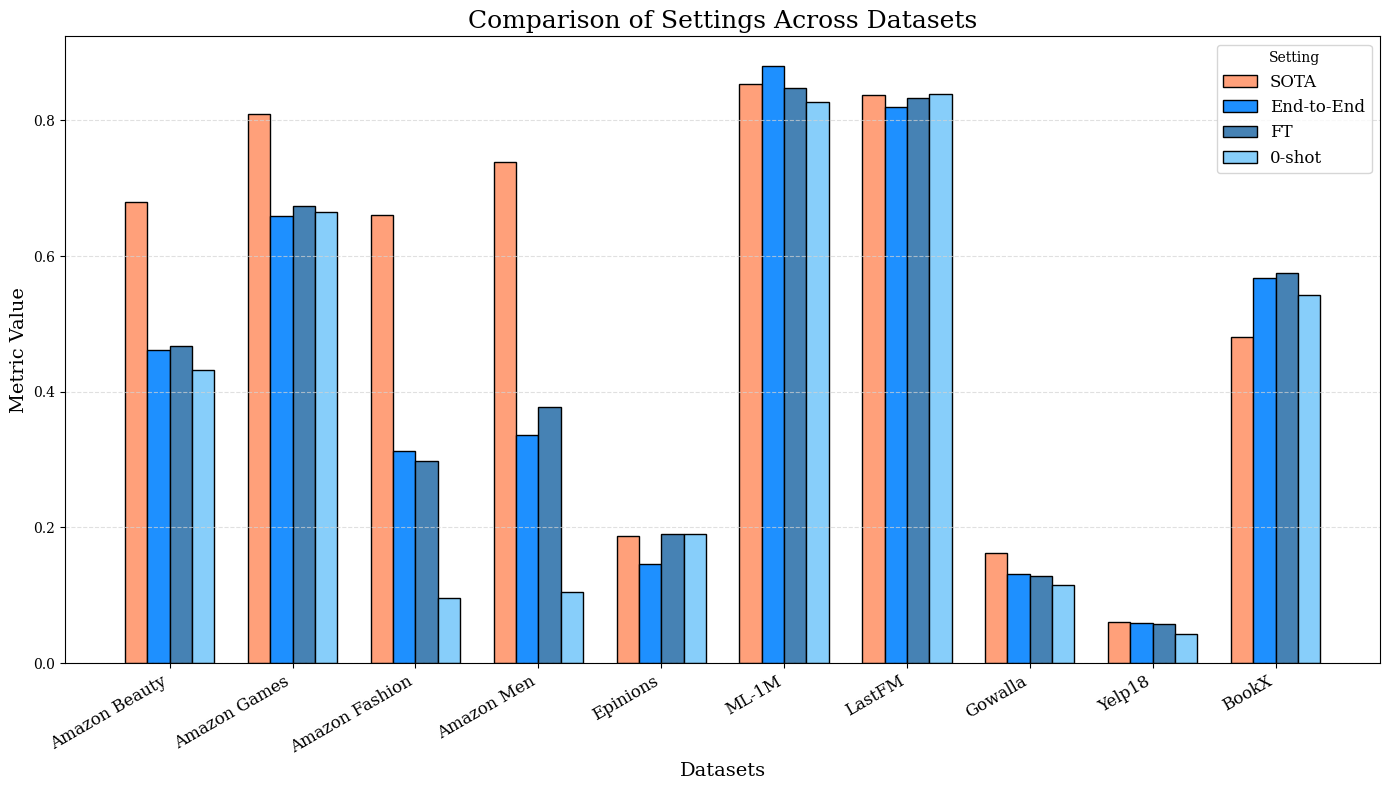

Plot saved to /itet-stor/trachsele/net_scratch/tl4rec/report_data/result_summary.png


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load the CSV file
plot_path = '/itet-stor/trachsele/net_scratch/tl4rec/report_data/result_summary.png'
csv_path = '/itet-stor/trachsele/net_scratch/tl4rec/report_data/ete_sota_0_shot_ft.csv'
df = pd.read_csv(csv_path)

# Use a serif font for better LaTeX compatibility
plt.rcParams["font.family"] = "serif"

# Rename dataset labels to match the heatmap
def rename_dataset(name):
    if name == "Ml1m":
        return "ML-1M"
    elif name.startswith("Amazon_"):
        return name.replace("_", " ")  # Convert underscores to spaces
    elif name == "Yelp":
        return "Yelp18"
    return name

df["dataset"] = df["dataset"].apply(rename_dataset)

# Define the desired dataset order
desired_order = ["Amazon Beauty", "Amazon Games", "Amazon Fashion", "Amazon Men", 
                 "Epinions", "ML-1M", "LastFM", "Gowalla", "Yelp18", "BookX"]

# Sort datasets according to the desired order
df["dataset"] = pd.Categorical(df["dataset"], categories=desired_order, ordered=True)
df = df.sort_values("dataset")  # Ensure consistent order in the plot

# Define settings order for plotting
settings_order = ['SOTA', 'End-to-End', 'FT', '0-shot']

# Extract metric values per dataset and setting
metric_by_ds = {}
for ds in desired_order:
    metric_col = "test_ndcg@20" if ds in ["Gowalla", "Yelp18"] else "test_hits@10"
    metric_by_ds[ds] = {'metric_col': metric_col, 'values': {}}
    for setting in settings_order:
        row = df[(df['dataset'] == ds) & (df['setting'] == setting)]
        value = row.iloc[0][metric_col] if not row.empty else np.nan
        metric_by_ds[ds]['values'][setting] = value

# Prepare plotting parameters
n_datasets = len(desired_order)
n_settings = len(settings_order)
bar_width = 0.2
x = np.arange(n_datasets) * (n_settings * bar_width + 0.3)  # Add spacing between datasets

# Define colors for each setting
colors = {
    'SOTA': '#FFA07A',  # Light orange
    'End-to-End': '#1E90FF',  # Dodger blue
    'FT': '#4682B4',  # Steel blue
    '0-shot': '#87CEFA'  # Light sky blue
}

# Create the plot
plt.figure(figsize=(14, 8))
for i, setting in enumerate(settings_order):
    offset = i * bar_width
    values = [metric_by_ds[ds]['values'][setting] for ds in desired_order]
    plt.bar(x + offset, values, width=bar_width, color=colors[setting], label=setting, edgecolor='black')

# Update x-axis labels
plt.xticks(x + (n_settings / 2 - 0.5) * bar_width, desired_order, rotation=30, ha='right', fontsize=12)
plt.xlabel("Datasets", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)
plt.title("Comparison of Settings Across Datasets", fontsize=18)
plt.grid(axis='y', linestyle='--', color='lightgray', alpha=0.7)
plt.legend(title="Setting", fontsize=12)
plt.tight_layout()

# Ensure the directory exists
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
plt.show()

# Save the plot
#plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Plot saved to {plot_path}")


In [2]:
import sqlite3
import pandas as pd
import itertools
# generates results_heat_map.csv

# Database and CSV file paths
DB_FILE = "//itet-stor/trachsele/net_scratch/tl4rec/model_outputs/results.db"
CSV_FILE = "/itet-stor/trachsele/net_scratch/tl4rec/report_data/results_heat_map.csv"

# List of datasets and desired checkpoints
DATASETS = [
    "Epinions", "LastFM", "BookX", "Ml1m", "Gowalla",
    "Amazon_Beauty", "Amazon_Fashion", "Amazon_Men", "Amazon_Games", "Yelp18"
]

CKPTS = [
    "Amazon_Beauty.pth",
    "Amazon_Games.pth",
    "Amazon_Fashion.pth",
    "Amazon_Men.pth",
    "Epinions.pth",
    "Ml1m.pth",
    "LastFM.pth",
    "Gowalla.pth",
    "Yelp.pth",
    "BookX.pth"
]

# Connect to the database and load the 0-shot data for the given checkpoints
conn = sqlite3.connect(DB_FILE)
ckpts_str = ",".join(f"'{ckpt}'" for ckpt in CKPTS)
query = f"""
SELECT *
FROM experiments
WHERE epochs = 0
  AND ckpt IN ({ckpts_str})
;
"""
df = pd.read_sql(query, conn)
conn.close()

# Identify metric columns to average.
# We assume keys like 'dataset', 'ckpt', 'epochs', 'bpe', 'FT' should not be averaged.
non_metric_cols = ['dataset', 'ckpt', 'epochs', 'bpe', 'FT']
metric_columns = [col for col in df.columns if col not in non_metric_cols]

# Compute per-dataset averages from the available data
group_avg = df.groupby('dataset')[metric_columns].mean().reset_index()

# Create a DataFrame with all 100 dataset-ckpt combinations
all_combinations = pd.DataFrame(list(itertools.product(DATASETS, CKPTS)), columns=['dataset', 'ckpt'])

# Merge the available data onto the full grid (left join ensures all combinations remain)
merged = pd.merge(all_combinations, df, on=['dataset', 'ckpt'], how='left')

# Fill missing metric values with the average for the corresponding dataset.
# For each metric column, if the value is missing, we look up the dataset's average.
for col in metric_columns:
    merged[col] = merged.apply(
        lambda row: group_avg.loc[group_avg['dataset'] == row['dataset'], col].values[0]
                    if pd.isna(row[col]) else row[col],
        axis=1
    )

# Optionally, you might want to fill or adjust non-metric columns as needed.
# For example, you can set epochs = 0 for the newly inserted rows.
merged['epochs'] = 0

# Save the resulting DataFrame to a CSV file
merged.to_csv(CSV_FILE, index=False)

# Display the first few rows of the final DataFrame
print(merged.head())


    dataset                ckpt  epochs     bpe   FT  valid_mr  valid_mrr  \
0  Epinions   Amazon_Beauty.pth       0  5130.0  0.0       NaN   0.373743   
1  Epinions    Amazon_Games.pth       0  5130.0  0.0       NaN   0.375822   
2  Epinions  Amazon_Fashion.pth       0  5130.0  0.0       NaN   0.344563   
3  Epinions      Amazon_Men.pth       0  5130.0  0.0       NaN   0.298499   
4  Epinions        Epinions.pth       0  5130.0  0.0       NaN   0.361130   

   valid_hits@1  valid_hits@3  valid_hits@10  valid_ndcg@10  test_mr  \
0      0.256808      0.425199       0.605657       0.249757      NaN   
1      0.259379      0.427177       0.608954       0.252030      NaN   
2      0.232347      0.394475       0.565504       0.221988      NaN   
3      0.192523      0.331773       0.519351       0.193697      NaN   
4      0.244346      0.412079       0.593657       0.239248      NaN   

   test_mrr  test_hits@1  test_hits@3  test_hits@10  test_ndcg@10  \
0  0.104845     0.055708     0.1108

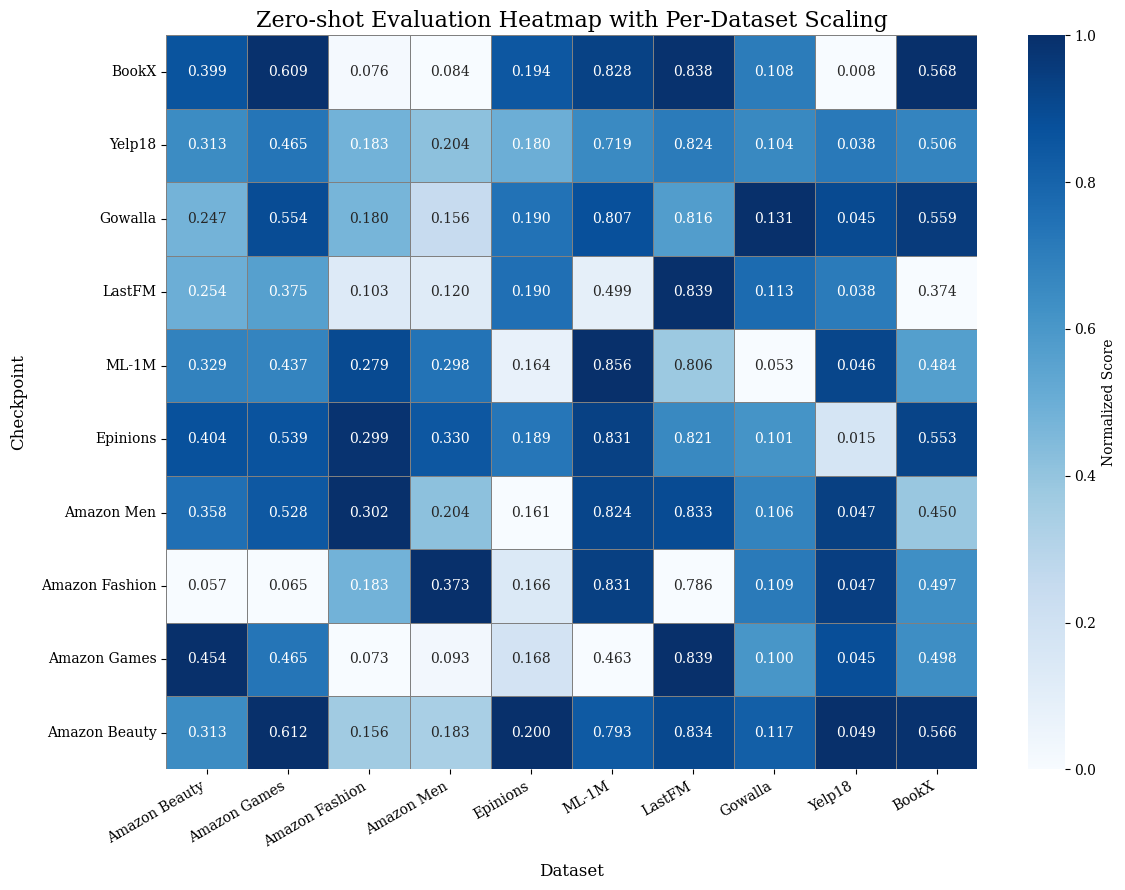

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV into a DataFrame
CSV_FILE = "/itet-stor/trachsele/net_scratch/tl4rec/report_data/results_heat_map.csv"
df = pd.read_csv(CSV_FILE)
plot_path = '/itet-stor/trachsele/net_scratch/tl4rec/report_data/heatmap.png'
# Use a serif font for better LaTeX compatibility
plt.rcParams["font.family"] = "serif"

# Rename dataset and checkpoint labels
def rename_dataset(name):
    if name == "Ml1m":
        return "ML-1M"
    elif name.startswith("Amazon_"):
        return name.replace("_", " ")
    elif name == "Yelp":
        return "Yelp18"
    return name

df["dataset"] = df["dataset"].apply(rename_dataset)
df["ckpt"] = df["ckpt"].str.replace(".pth", "", regex=False).apply(rename_dataset)

# Select the correct metric
def get_target_metric(row):
    return row["test_ndcg@20"] if row["dataset"] in ["Gowalla", "Yelp18"] else row["test_hits@10"]

df["target_metric"] = df.apply(get_target_metric, axis=1)

# Normalize target_metric per dataset **before pivoting**
df["normalized_target_metric"] = df.groupby("dataset")["target_metric"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0
)

# Define dataset order (x-axis stays as before)
desired_order = ["Amazon Beauty", "Amazon Games", "Amazon Fashion", "Amazon Men", 
                 "Epinions", "ML-1M", "LastFM", "Gowalla", "Yelp18", "BookX"]

# Reverse the y-axis order (checkpoints)
reversed_order = desired_order[::-1]  # This reverses the list

# Pivot DataFrame for heatmap structure (ckpt as rows, dataset as columns)
pivot_original = df.pivot(index="ckpt", columns="dataset", values="target_metric")
pivot_normalized = df.pivot(index="ckpt", columns="dataset", values="normalized_target_metric")

# Apply ordering (x-axis normal, y-axis reversed)
pivot_original = pivot_original.reindex(index=reversed_order, columns=desired_order)
pivot_normalized = pivot_normalized.reindex(index=reversed_order, columns=desired_order)

# Plot the heatmap with Blue for 1.0 and White for 0.0
plt.figure(figsize=(12, 9))
ax = sns.heatmap(pivot_normalized, annot=pivot_original, fmt=".3f", cmap="Blues",
                 linewidths=0.7, linecolor="gray", cbar_kws={'label': 'Normalized Score'},
                 annot_kws={"size": 10}, vmin=0, vmax=1)

# Improve labels
plt.title("Zero-shot Evaluation Heatmap with Per-Dataset Scaling", fontsize=16)
plt.xlabel("Dataset", fontsize=12, labelpad=10)
plt.ylabel("Checkpoint", fontsize=12, labelpad=10)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

os.makedirs(os.path.dirname(plot_path), exist_ok=True)

# Save the plot
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
#plt.show()
# Save high-quality version
#plt.savefig("heatmap.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


pdfTeX 3.1415926-1.40.9-2.2 (Web2C 7.5.7)
kpathsea version 3.5.7
Copyright 2008 Peter Breitenlohner (eTeX)/Han The Thanh (pdfTeX).
Kpathsea is copyright 2008 Karl Berry and Olaf Weber.
There is NO warranty.  Redistribution of this software is
covered by the terms of both the pdfTeX copyright and
the Lesser GNU General Public License.
For more information about these matters, see the file
named COPYING and the pdfTeX source.
Primary author of pdfTeX: Peter Breitenlohner (eTeX)/Han The Thanh (pdfTeX).
Kpathsea written by Karl Berry, Olaf Weber, and others.

Compiled with libpng 1.2.29; using libpng 1.2.29
Compiled with zlib 1.2.3; using zlib 1.2.3
Compiled with xpdf version 3.02pl2

This is dvipng 1.11 Copyright 2002-2008 Jan-Ake Larsson
dvipng 1.11
kpathsea version 3.5.7
Compiled with Freetype 2.3.7
Using libft 2.3.7
Using t1lib 5.0.2
Copyright (C) 2002-2008 Jan-Ake Larsson.
There is NO warranty.  You may redistribute this software
under the terms of the GNU Lesser General Public Licens

0